In [2]:
import cv2
import numpy as np
import json
import os
import matplotlib.pyplot as plt


from mrcnn.config import Config
import mrcnn.utils as utils
import mrcnn.model as modellib
import mrcnn.visualize as visualize

import os
import numpy as np
import cv2
import json

import matplotlib.pyplot as plt

import pandas as pd

Using TensorFlow backend.


In [2]:
!pip install -U scikit-image

  Using cached scikit_image-0.19.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.0 MB)
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.2
    Uninstalling scikit-image-0.19.2:
      Successfully uninstalled scikit-image-0.19.2


In [3]:
# Import the Mask R-CNN model
from mrcnn.model import MaskRCNN
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.config import Config
from mrcnn import model as modellib, utils

In [4]:
dir_path = os.getcwd()
print(dir_path)
MODEL_DIR = dir_path
COCO_MODEL_PATH = dir_path + "/mask_rcnn_coco.h5"

/host/Mask-RCNN-TF2


In [5]:
class MolesConfig(Config):
    ''' 
    MolesConfig:
        Contain the configuration for the dataset + those in Config
    '''
    NAME = "moles"
    GPU_COUNT = 1 # put 2 or more if you are 1 or more gpu
    IMAGES_PER_GPU = 1 # if you are a gpu you are choose how many image to process per gpu
    NUM_CLASSES = 1 + 2  # background + (malignant , benign)
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # hyperparameter
    LEARNING_RATE = 0.001
    STEPS_PER_EPOCH = 75
    VALIDATION_STEPS = 5


In [6]:
class LesionDataset(utils.Dataset):
    def load_lesions(self, dataset_dir, subset):
        """Load a subset of the lesions dataset.

        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes
        self.add_class("lesions", 1, "lesion")

        # Load annotations
        annotations = pd.read_csv(os.path.join(dataset_dir, "annotation.csv"))
        annotations = annotations[annotations['subset'] == subset]
        annotations = annotations.reset_index(drop=True)

        # Load image and masks
        for i in range(annotations.shape[0]):
            image_path = os.path.join(dataset_dir, annotations['ImageIndex'][i])
            mask_path = os.path.join(dataset_dir, "Segmentation", annotations['ImageIndex'].apply(lambda x: x.split(".")[0] + ".png"))

            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            self.add_image("lesions", image_id=i, path=image_path,
                            width=image.shape[1], height=image.shape[0],
                            mask=mask)
            

In [7]:
class SkinLesionConfig(Config):
    # Give the configuration a recognizable name
    NAME = "skin_lesion_cfg"
    
    # Set batch size to 1 since you'll be running inference on one image at a time.
    # Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1+1  # Background + skin lesion

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    



In [8]:
lesion = {
    'nv': 'malignant',
    'mel': 'malignant',
    'bkl': 'benign',
    'bcc': 'malignant',
    'akiec': 'malignant',
    'vasc': 'malignant',
    'df': 'malignant'
}

In [11]:
model =MaskRCNN(mode="inference", 
                             config=SkinLesionConfig(),
                             model_dir='./')

AttributeError: module 'tensorflow' has no attribute 'math'

In [9]:
config = SkinLesionConfig()
model = MaskRCNN(mode="training", config=config, model_dir='./')
model.load_weights("mask_rcnn_coco.h5", by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])


AttributeError: module 'tensorflow' has no attribute 'random'

In [10]:
class Metadata:
    ''' 
    Metadata:
        Contain everything about an image
        - Mask
        - Image
        - Description
    '''
    def __init__(self, lesion, img, mask):
        #self.meta = meta
        self.img = img
        self.type = lesion
        self.mask = mask


In [11]:
class MoleDataset(utils.Dataset):
    ''' 
    MoleDataset:
        Used to process the data
    '''
    def load_shapes(self, dataset, height, width):
        ''' Add the 2 class of skin cancer and put the metadata inside the model'''
        self.add_class("moles", 1, "malignant")
        self.add_class("moles", 2, "benign")

        for i, info in enumerate(dataset):
            height, width, channels = info.img.shape
            self.add_image(source="moles", image_id=i, path=None,
                           width=width, height=height,
                           img=info.img, shape=(info.type, channels, (height, width)),
                           mask=info.mask, extra=info)

    def load_image(self, image_id):
        return self.image_info[image_id]["img"]

    def image_reference(self, image_id):
        if self.image_info[image_id]["source"] == "moles":
            return self.image_info[image_id]["shape"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        ''' load the mask and return mask and the class of the image '''
        info = self.image_info[image_id]
        shapes = info["shape"]
        mask = info["mask"].astype(np.uint8)
        class_ids=np.array([self.class_names.index(shapes[0])])
        return mask, class_ids.astype(np.int32)

In [12]:
metadata = pd.read_csv('HAM10000_metadata.csv')

In [13]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [14]:
metadata['dx']=metadata['dx'].astype('str')

In [15]:
def data(x):
    return metadata[metadata['image_id']==x]
     

In [16]:
filename ='ISIC_0024349'
data(filename)

,lesion_id,image_id,dx,dx_type,age,sex,localization
8336,HAM_0000025,ISIC_0024349,nv,histo,35.0,male,lower extremity


In [17]:
config = MolesConfig()
all_info = []

# path of Data that contain Descriptions and Images
path_data = dir_path
if not os.path.exists(path_data):
    raise Exception(path_data + " Does not exists")

warning = True

# Load all the images, mask of the Dataset

for filename in os.listdir(path_data+"/ISIC-images/Images/"):
    print(filename)
    if len(filename) > 16:
        if warning:
            print("Maybe the filename is wrong, should be something like: ISIC_0000000 , not ISIC_0000000.json or something else")
            print("Now the filename is "+ filename[:12]+ " check that is correct")
            warning = False
        filename = filename[:12]

    filename = filename.split('.')[0]
    print(filename)

    #data = json.load(open(path_data+"/ISIC-images/Description/"+filename+".json"))
    #print(data)
    img = cv2.imread(path_data+"/ISIC-images/Images/"+filename+".jpg")
    print(img)
    
    img = cv2.resize(img, (128, 128))
    mask = cv2.imread(path_data+"/ISIC-images/Segmentation/"+filename+"_segmentation.png")
    print(mask)
    if mask.all() == 1:
        break
        continue
    mask = cv2.resize(mask, (128, 128))
    
    info = Metadata(lesion[data(filename).iloc[0][2]],img, mask)
    all_info.append(info)

ISIC_0024349.jpg
ISIC_0024349
[[[165 144 177]
  [166 143 181]
  [164 139 177]
  ...
  [167 127 185]
  [167 126 184]
  [165 125 183]]

 [[169 144 178]
  [168 143 181]
  [164 140 182]
  ...
  [164 126 184]
  [166 126 184]
  [166 125 186]]

 [[174 145 184]
  [170 143 183]
  [166 141 185]
  ...
  [166 128 186]
  [164 126 186]
  [164 124 182]]

 ...

 [[184 150 197]
  [184 150 197]
  [186 152 199]
  ...
  [176 132 203]
  [181 137 208]
  [177 131 204]]

 [[184 151 196]
  [185 152 197]
  [186 152 199]
  ...
  [169 128 203]
  [172 126 202]
  [167 121 197]]

 [[185 150 200]
  [186 151 201]
  [187 152 202]
  ...
  [162 120 197]
  [158 114 191]
  [154 108 185]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
ISIC_0024324.jpg
ISIC_0024324
[[[171 145 168]
  [166 145 167]
  [167 147 166]
  ...
  [170 148 166]
  [173 149 167]
  [172 150 169]]

 [[171 147 165]
  [166 147 164]
  [166 147 164]
  ...
  [171 149 167]
  [174 150 168]
  [173 148 168]]

 [[167 145 163]
  [165 146 163]
  [165 146 163]
  ...
  [172 150 168]
  [172 148 166]
  [174 149 169]]

 ...

 [[163 141 169]
  [162 140 168]
  [165 140 166]
  ...
  [165 146 165]
  [166 147 168]
  [167 145 169]]

 [[162 140 164]
  [165 144 166]
  [163 141 160]
  ...
  [164 145 164]
  [165 146 167]
  [166 145 167]]

 [[166 140 163]
  [165 142 164

[[[165 137 167]
  [169 136 171]
  [169 136 171]
  ...
  [176 143 178]
  [178 145 180]
  [180 144 180]]

 [[164 137 171]
  [169 135 172]
  [169 135 172]
  ...
  [176 144 175]
  [176 145 176]
  [179 147 178]]

 [[164 133 170]
  [169 134 174]
  [168 134 171]
  ...
  [178 147 180]
  [177 144 178]
  [178 145 179]]

 ...

 [[144 116 162]
  [143 116 160]
  [145 118 162]
  ...
  [173 141 176]
  [172 139 173]
  [174 142 173]]

 [[142 115 159]
  [143 116 160]
  [142 115 159]
  ...
  [173 141 176]
  [171 138 173]
  [173 140 174]]

 [[142 117 155]
  [142 117 155]
  [141 116 154]
  ...
  [173 141 176]
  [173 140 175]
  [174 139 173]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0

ISIC_0024370.jpg
ISIC_0024370
[[[136 129 204]
  [132 128 203]
  [143 130 208]
  ...
  [150 142 203]
  [150 144 203]
  [152 146 205]]

 [[141 131 208]
  [138 128 204]
  [147 131 208]
  ...
  [146 144 204]
  [153 142 204]
  [152 144 207]]

 [[139 132 207]
  [141 131 207]
  [140 129 209]
  ...
  [143 144 205]
  [143 144 202]
  [146 144 204]]

 ...

 [[159 151 204]
  [160 151 202]
  [157 147 200]
  ...
  [132 122 188]
  [133 126 193]
  [132 121 191]]

 [[160 149 205]
  [163 152 208]
  [164 149 206]
  ...
  [134 126 191]
  [135 128 195]
  [128 118 188]]

 [[160 153 204]
  [159 149 202]
  [164 151 203]
  ...
  [131 125 190]
  [123 121 187]
  [125 120 189]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
ISIC_0024385.jpg
ISIC_0024385
[[[155 142 234]
  [158 146 234]
  [155 143 233]
  ...
  [171 161 238]
  [169 159 235]
  [166 159 234]]

 [[153 144 235]
  [155 146 236]
  [153 143 233]
  ...
  [170 159 232]
  [166 159 232]
  [166 157 230]]

 [[154 141 233]
  [158 143 235]
  [156 140 234]
  ...
  [171 160 232]
  [170 161 234]
  [168 159 232]]

 ...

 [[140 133 206]
  [135 131 206]
  [137 130 203]
  ...
  [150 146 212]
  [146 145 209]
  [145 144 210]]

 [[134 134 204]
  [132 132 202]
  [134 130 201]
  ...
  [154 147 214]
  [154 146 211]
  [155 145 211]]

 [[136 131 206]
  [134 129 204

[[[ 89  94 196]
  [ 85  90 192]
  [ 79  89 190]
  ...
  [142 126 197]
  [137 125 191]
  [134 120 191]]

 [[ 75  88 186]
  [ 82  93 191]
  [ 85  97 191]
  ...
  [135 124 194]
  [135 124 196]
  [133 125 196]]

 [[ 77  89 185]
  [ 87  94 191]
  [ 90  98 188]
  ...
  [136 121 195]
  [135 119 196]
  [128 115 191]]

 ...

 [[ 65  51 109]
  [ 74  60 118]
  [ 82  68 126]
  ...
  [120 113 174]
  [114 112 172]
  [117 112 173]]

 [[ 74  66 119]
  [ 82  73 130]
  [ 94  82 142]
  ...
  [121 110 173]
  [118 110 171]
  [120 112 173]]

 [[ 91  82 145]
  [102  93 156]
  [117 105 171]
  ...
  [120 112 173]
  [115 108 169]
  [116 108 171]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0

[[[139 136 221]
  [143 137 224]
  [138 135 221]
  ...
  [140 137 217]
  [140 134 215]
  [134 129 208]]

 [[142 133 223]
  [141 135 222]
  [137 134 220]
  ...
  [140 141 215]
  [137 137 213]
  [131 132 212]]

 [[139 133 220]
  [135 134 220]
  [133 132 218]
  ...
  [145 139 221]
  [141 135 216]
  [144 138 219]]

 ...

 [[117 119 203]
  [115 119 198]
  [116 124 201]
  ...
  [125 130 205]
  [124 130 201]
  [124 130 201]]

 [[115 120 199]
  [115 122 201]
  [115 122 201]
  ...
  [131 131 209]
  [130 129 203]
  [130 133 207]]

 [[118 122 200]
  [116 120 198]
  [115 119 197]
  ...
  [125 129 207]
  [127 129 207]
  [126 130 208]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0

[[[131 119 207]
  [140 123 214]
  [135 119 207]
  ...
  [144 126 209]
  [144 125 210]
  [145 131 209]]

 [[132 116 204]
  [135 122 208]
  [132 119 205]
  ...
  [147 128 213]
  [147 128 213]
  [147 131 215]]

 [[128 110 201]
  [131 114 205]
  [133 117 205]
  ...
  [141 128 206]
  [144 132 208]
  [146 132 210]]

 ...

 [[122 120 190]
  [123 120 192]
  [119 118 190]
  ...
  [132 123 190]
  [132 121 189]
  [132 124 189]]

 [[117 116 188]
  [121 120 192]
  [123 118 193]
  ...
  [129 121 191]
  [130 121 188]
  [135 126 193]]

 [[111 110 190]
  [117 117 193]
  [119 113 190]
  ...
  [127 125 191]
  [131 127 192]
  [130 126 191]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0

[[[135 123 213]
  [133 122 215]
  [134 123 219]
  ...
  [156 142 224]
  [159 147 229]
  [156 144 226]]

 [[133 123 213]
  [134 125 216]
  [133 124 215]
  ...
  [156 144 226]
  [157 145 227]
  [157 144 228]]

 [[133 121 211]
  [133 122 215]
  [132 121 214]
  ...
  [158 143 227]
  [157 142 226]
  [157 142 226]]

 ...

 [[117 121 199]
  [118 127 200]
  [120 125 200]
  ...
  [141 135 206]
  [142 135 208]
  [143 137 208]]

 [[120 121 202]
  [120 121 201]
  [122 123 203]
  ...
  [140 134 205]
  [140 138 208]
  [144 143 209]]

 [[116 122 199]
  [117 122 197]
  [121 125 203]
  ...
  [143 132 204]
  [144 137 210]
  [143 139 211]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0

In [18]:
img.shape

(128, 128, 3)

In [19]:
# split the data into train and test
percentual = (len(all_info)*30)//100
np.random.shuffle(all_info)
train_data = all_info[:-percentual]
val_data = all_info[percentual+1:]


In [20]:
# processing the data
dataset_train = MoleDataset()
dataset_train.load_shapes(train_data, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()
dataset_val = MoleDataset()
dataset_val.load_shapes(val_data, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()



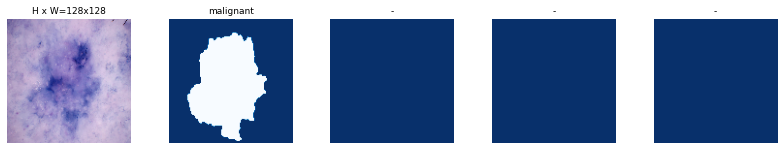

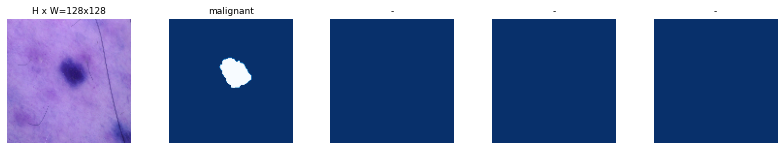

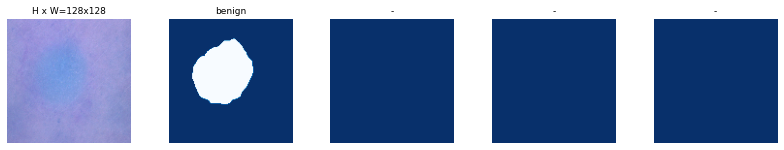

In [21]:
# Show some random images to verify that everything is ok
image_ids = np.random.choice(dataset_train.image_ids, 3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [22]:
# Create the MaskRCNN model
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

# Use as start point the coco model
model.load_weights(COCO_MODEL_PATH, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                            "mrcnn_bbox", "mrcnn_mask"])

# Train the model on the train dataset
# First only the header layers
model.log_dir = './logs/train'
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=15,
            layers='heads')
# After all the layers 
#model.train(dataset_train, dataset_val,
#            learning_rate=config.LEARNING_RATE/10,
#            epochs=25,
 #           layers="all")

#print("Trained finished!")



Starting at epoch 0. LR=0.001

Checkpoint Path: //logdir//train/mask_rcnn_moles_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
m

2023-02-11 13:59:44.554182: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
/home/michael/anaconda3/envs/MaskRCNNTF2/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/michael/anaconda3/envs/MaskRCNNTF2/lib/python3.7/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/15


ERROR:root:Error processing image {'id': 55, 'source': 'moles', 'path': None, 'width': 128, 'height': 128, 'img': array([[[250, 217, 244],
        [254, 218, 244],
        [252, 221, 244],
        ...,
        [253, 204, 222],
        [250, 204, 219],
        [249, 200, 214]],

       [[249, 212, 239],
        [247, 216, 244],
        [251, 218, 244],
        ...,
        [252, 206, 225],
        [250, 199, 218],
        [243, 195, 215]],

       [[241, 210, 242],
        [254, 217, 244],
        [253, 219, 247],
        ...,
        [253, 206, 224],
        [250, 197, 219],
        [242, 197, 216]],

       ...,

       [[230, 196, 211],
        [236, 199, 212],
        [237, 200, 216],
        ...,
        [236, 201, 216],
        [237, 200, 214],
        [234, 198, 209]],

       [[233, 202, 212],
        [232, 195, 210],
        [235, 198, 213],
        ...,
        [241, 203, 219],
        [241, 203, 215],
        [220, 189, 204]],

       [[228, 198, 208],
        [229, 198, 208]

ERROR:root:Error processing image {'id': 55, 'source': 'moles', 'path': None, 'width': 128, 'height': 128, 'img': array([[[250, 217, 244],
        [254, 218, 244],
        [252, 221, 244],
        ...,
        [253, 204, 222],
        [250, 204, 219],
        [249, 200, 214]],

       [[249, 212, 239],
        [247, 216, 244],
        [251, 218, 244],
        ...,
        [252, 206, 225],
        [250, 199, 218],
        [243, 195, 215]],

       [[241, 210, 242],
        [254, 217, 244],
        [253, 219, 247],
        ...,
        [253, 206, 224],
        [250, 197, 219],
        [242, 197, 216]],

       ...,

       [[230, 196, 211],
        [236, 199, 212],
        [237, 200, 216],
        ...,
        [236, 201, 216],
        [237, 200, 214],
        [234, 198, 209]],

       [[233, 202, 212],
        [232, 195, 210],
        [235, 198, 213],
        ...,
        [241, 203, 219],
        [241, 203, 215],
        [220, 189, 204]],

       [[228, 198, 208],
        [229, 198, 208]

ERROR:root:Error processing image {'id': 6, 'source': 'moles', 'path': None, 'width': 128, 'height': 128, 'img': array([[[148, 137, 165],
        [147, 135, 165],
        [148, 136, 166],
        ...,
        [155, 141, 165],
        [160, 147, 171],
        [163, 147, 172]],

       [[149, 135, 163],
        [149, 137, 167],
        [148, 136, 166],
        ...,
        [157, 143, 167],
        [162, 147, 171],
        [159, 145, 169]],

       [[150, 136, 164],
        [147, 135, 165],
        [147, 135, 165],
        ...,
        [155, 141, 165],
        [158, 142, 166],
        [160, 146, 170]],

       ...,

       [[155, 142, 168],
        [151, 141, 168],
        [153, 141, 168],
        ...,
        [156, 142, 166],
        [154, 140, 164],
        [155, 141, 165]],

       [[156, 143, 168],
        [154, 141, 167],
        [157, 144, 167],
        ...,
        [156, 142, 166],
        [155, 141, 165],
        [154, 140, 164]],

       [[156, 142, 166],
        [154, 141, 167],

ERROR:root:Error processing image {'id': 58, 'source': 'moles', 'path': None, 'width': 128, 'height': 128, 'img': array([[[ 84,  96, 139],
        [ 85,  96, 138],
        [ 89,  99, 144],
        ...,
        [ 72,  80, 123],
        [ 67,  76, 119],
        [ 68,  77, 119]],

       [[ 77,  89, 131],
        [ 79,  94, 138],
        [ 84,  94, 137],
        ...,
        [ 76,  84, 127],
        [ 68,  77, 120],
        [ 71,  80, 123]],

       [[ 77,  89, 132],
        [ 78,  90, 133],
        [ 85,  92, 137],
        ...,
        [ 78,  87, 130],
        [ 72,  81, 124],
        [ 70,  79, 123]],

       ...,

       [[ 74,  86, 128],
        [ 71,  83, 125],
        [ 75,  84, 127],
        ...,
        [ 75,  78, 112],
        [ 77,  75, 111],
        [ 75,  74, 108]],

       [[ 76,  85, 128],
        [ 75,  84, 127],
        [ 71,  80, 123],
        ...,
        [ 75,  73, 110],
        [ 74,  72, 109],
        [ 70,  69, 101]],

       [[ 72,  82, 121],
        [ 72,  81, 125]

ERROR:root:Error processing image {'id': 6, 'source': 'moles', 'path': None, 'width': 128, 'height': 128, 'img': array([[[148, 137, 165],
        [147, 135, 165],
        [148, 136, 166],
        ...,
        [155, 141, 165],
        [160, 147, 171],
        [163, 147, 172]],

       [[149, 135, 163],
        [149, 137, 167],
        [148, 136, 166],
        ...,
        [157, 143, 167],
        [162, 147, 171],
        [159, 145, 169]],

       [[150, 136, 164],
        [147, 135, 165],
        [147, 135, 165],
        ...,
        [155, 141, 165],
        [158, 142, 166],
        [160, 146, 170]],

       ...,

       [[155, 142, 168],
        [151, 141, 168],
        [153, 141, 168],
        ...,
        [156, 142, 166],
        [154, 140, 164],
        [155, 141, 165]],

       [[156, 143, 168],
        [154, 141, 167],
        [157, 144, 167],
        ...,
        [156, 142, 166],
        [155, 141, 165],
        [154, 140, 164]],

       [[156, 142, 166],
        [154, 141, 167],

ERROR:root:Error processing image {'id': 3, 'source': 'moles', 'path': None, 'width': 128, 'height': 128, 'img': array([[[46, 40, 62],
        [55, 52, 73],
        [68, 64, 91],
        ...,
        [56, 50, 68],
        [41, 35, 52],
        [34, 27, 43]],

       [[48, 45, 68],
        [61, 60, 81],
        [70, 66, 97],
        ...,
        [63, 56, 77],
        [47, 42, 58],
        [39, 32, 45]],

       [[52, 47, 77],
        [64, 59, 90],
        [75, 75, 98],
        ...,
        [70, 64, 83],
        [55, 50, 66],
        [41, 35, 53]],

       ...,

       [[34, 33, 48],
        [39, 37, 56],
        [49, 43, 69],
        ...,
        [18, 14, 21],
        [ 8,  7, 15],
        [ 6,  5, 13]],

       [[31, 27, 45],
        [38, 32, 54],
        [44, 37, 61],
        ...,
        [15,  7, 16],
        [ 5,  4, 13],
        [ 4,  3, 12]],

       [[27, 26, 44],
        [33, 30, 50],
        [40, 34, 58],
        ...,
        [ 5,  4, 13],
        [ 6,  5, 14],
        [ 1,  2,

ERROR:root:Error processing image {'id': 6, 'source': 'moles', 'path': None, 'width': 128, 'height': 128, 'img': array([[[161, 152, 231],
        [160, 147, 229],
        [160, 148, 229],
        ...,
        [164, 153, 229],
        [164, 154, 230],
        [161, 152, 232]],

       [[162, 153, 231],
        [158, 148, 231],
        [158, 149, 229],
        ...,
        [159, 152, 231],
        [163, 152, 226],
        [168, 157, 236]],

       [[155, 149, 228],
        [157, 151, 229],
        [154, 146, 227],
        ...,
        [161, 155, 230],
        [162, 153, 227],
        [165, 159, 231]],

       ...,

       [[139, 144, 215],
        [141, 143, 213],
        [145, 144, 215],
        ...,
        [153, 153, 214],
        [153, 151, 216],
        [155, 154, 218]],

       [[132, 135, 210],
        [136, 142, 212],
        [141, 147, 216],
        ...,
        [154, 152, 216],
        [153, 152, 214],
        [154, 153, 214]],

       [[130, 131, 210],
        [129, 130, 207],

ERROR:root:Error processing image {'id': 6, 'source': 'moles', 'path': None, 'width': 128, 'height': 128, 'img': array([[[161, 152, 231],
        [160, 147, 229],
        [160, 148, 229],
        ...,
        [164, 153, 229],
        [164, 154, 230],
        [161, 152, 232]],

       [[162, 153, 231],
        [158, 148, 231],
        [158, 149, 229],
        ...,
        [159, 152, 231],
        [163, 152, 226],
        [168, 157, 236]],

       [[155, 149, 228],
        [157, 151, 229],
        [154, 146, 227],
        ...,
        [161, 155, 230],
        [162, 153, 227],
        [165, 159, 231]],

       ...,

       [[139, 144, 215],
        [141, 143, 213],
        [145, 144, 215],
        ...,
        [153, 153, 214],
        [153, 151, 216],
        [155, 154, 218]],

       [[132, 135, 210],
        [136, 142, 212],
        [141, 147, 216],
        ...,
        [154, 152, 216],
        [153, 152, 214],
        [154, 153, 214]],

       [[130, 131, 210],
        [129, 130, 207],

ERROR:root:Error processing image {'id': 6, 'source': 'moles', 'path': None, 'width': 128, 'height': 128, 'img': array([[[161, 152, 231],
        [160, 147, 229],
        [160, 148, 229],
        ...,
        [164, 153, 229],
        [164, 154, 230],
        [161, 152, 232]],

       [[162, 153, 231],
        [158, 148, 231],
        [158, 149, 229],
        ...,
        [159, 152, 231],
        [163, 152, 226],
        [168, 157, 236]],

       [[155, 149, 228],
        [157, 151, 229],
        [154, 146, 227],
        ...,
        [161, 155, 230],
        [162, 153, 227],
        [165, 159, 231]],

       ...,

       [[139, 144, 215],
        [141, 143, 213],
        [145, 144, 215],
        ...,
        [153, 153, 214],
        [153, 151, 216],
        [155, 154, 218]],

       [[132, 135, 210],
        [136, 142, 212],
        [141, 147, 216],
        ...,
        [154, 152, 216],
        [153, 152, 214],
        [154, 153, 214]],

       [[130, 131, 210],
        [129, 130, 207],

ERROR:root:Error processing image {'id': 30, 'source': 'moles', 'path': None, 'width': 128, 'height': 128, 'img': array([[[189, 155, 181],
        [190, 158, 184],
        [188, 154, 181],
        ...,
        [172, 141, 170],
        [173, 143, 175],
        [174, 146, 176]],

       [[187, 158, 182],
        [190, 157, 183],
        [188, 155, 182],
        ...,
        [131,  93, 126],
        [159,  98, 124],
        [166, 125, 148]],

       [[188, 156, 183],
        [191, 157, 183],
        [192, 158, 185],
        ...,
        [132, 142, 172],
        [115, 124, 159],
        [122, 119, 150]],

       ...,

       [[170, 142, 165],
        [177, 146, 171],
        [182, 148, 173],
        ...,
        [171, 147, 172],
        [168, 145, 170],
        [162, 143, 166]],

       [[168, 140, 164],
        [172, 146, 169],
        [180, 147, 170],
        ...,
        [164, 141, 171],
        [164, 140, 172],
        [160, 138, 167]],

       [[163, 137, 161],
        [169, 143, 167]

ERROR:root:Error processing image {'id': 67, 'source': 'moles', 'path': None, 'width': 128, 'height': 128, 'img': array([[[153, 135, 219],
        [143, 136, 220],
        [152, 139, 220],
        ...,
        [130, 119, 210],
        [127, 109, 206],
        [137, 121, 214]],

       [[139, 129, 213],
        [136, 130, 218],
        [143, 137, 218],
        ...,
        [141, 123, 217],
        [131, 118, 211],
        [129, 116, 207]],

       [[135, 125, 212],
        [138, 133, 215],
        [149, 138, 224],
        ...,
        [140, 126, 214],
        [128, 119, 209],
        [125, 114, 206]],

       ...,

       [[132, 121, 202],
        [117, 113, 199],
        [129, 123, 205],
        ...,
        [119, 107, 198],
        [108, 103, 189],
        [114, 108, 189]],

       [[120, 121, 202],
        [126, 122, 204],
        [117, 120, 202],
        ...,
        [114, 108, 192],
        [103, 104, 188],
        [112, 108, 194]],

       [[112, 117, 198],
        [120, 117, 203]

ERROR:root:Error processing image {'id': 31, 'source': 'moles', 'path': None, 'width': 128, 'height': 128, 'img': array([[[ 86,  97, 190],
        [108, 116, 199],
        [128, 132, 216],
        ...,
        [139, 124, 198],
        [142, 122, 198],
        [135, 123, 194]],

       [[ 98, 107, 195],
        [126, 130, 214],
        [129, 136, 218],
        ...,
        [135, 123, 202],
        [ 97,  87, 170],
        [ 56,  47, 113]],

       [[121, 126, 214],
        [118, 126, 213],
        [122, 126, 212],
        ...,
        [ 71,  61, 118],
        [ 89,  80, 142],
        [123, 111, 178]],

       ...,

       [[125, 125, 190],
        [ 70,  65, 128],
        [ 75,  70, 130],
        ...,
        [127, 118, 180],
        [123, 116, 179],
        [124, 112, 178]],

       [[ 61,  57, 118],
        [ 80,  71, 129],
        [128, 119, 188],
        ...,
        [122, 119, 180],
        [125, 116, 178],
        [120, 111, 174]],

       [[ 89,  77, 136],
        [123, 120, 185]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 3

In [35]:
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

In [36]:
model.load_weights(COCO_MODEL_PATH, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                            "mrcnn_bbox", "mrcnn_mask"])

In [31]:

model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=25,layers="all")



Starting at epoch 0. LR=0.0001

Checkpoint Path: //logdir//train/mask_rcnn_moles_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchNorm)
res3a_

2023-02-10 19:57:21.062157: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7f5e5b3175f0>
Traceback (most recent call last):
  File "/home/michael/anaconda3/envs/MaskRCNNTF2/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 434, in __del__
    context.remove_function(self.name)
  File "/home/michael/anaconda3/envs/MaskRCNNTF2/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 2237, in remove_function
    context().remove_function(name)
  File "/home/michael/anaconda3/envs/MaskRCNNTF2/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 1105, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import glob

from mrcnn.config import Config
import mrcnn.utils as utils
import mrcnn.model as modellib
import mrcnn.visualize as visualize

np.set_printoptions(threshold=np.inf)

# path of the trained model
dir_path = './'
MODEL_DIR = dir_path + "/models/"
MODEL_PATH = MODEL_DIR +"/mask_rcnn_coco.h5"



In [38]:
class CocoConfig(Config):
    ''' 
    MolesConfig:
        Contain the configuration for the dataset + those in Config
    '''
    NAME = "moles"
    NUM_CLASSES = 1 + 2 # background + (malignant , benign)
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MAX_INSTANCES = 3

# create and instance of config
config = CocoConfig()

# take the trained model
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_weights(COCO_MODEL_PATH, by_name=True)

# background + (malignant , benign)
class_names = ["BG", "malignant", "benign"]
'''
img = cv2.imread(dir_path +"/ISIC_0034262.jpg")
img = cv2.resize(img, (128, 128))
if img.all():
   print("No Image")
#ground truth of the class
print(data["meta"]["clinical"]["benign_malignant"])
''' 

# predict the mask, bounding box and class of the image
for file in os.listdir(dir_path +"/test"):
    print(file)
    img = cv2.imread(dir_path +"/test/"+file)
    img = cv2.resize(img, (128, 128))
    r = model.detect([img])[0]
    print(r['class_ids'] , class_names , r['scores'])
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'],
                                class_names, r['scores'])


ValueError: Layer #389 (named "mrcnn_bbox_fc"), weight <tf.Variable 'mrcnn_bbox_fc_5/kernel:0' shape=(1024, 12) dtype=float32, numpy=
array([[-0.0438811 , -0.04495583,  0.03014846, ..., -0.00831714,
        -0.07000256,  0.05572653],
       [-0.03052835, -0.05996221, -0.06562172, ..., -0.03630493,
         0.06238019,  0.01063577],
       [ 0.00787228, -0.00513127, -0.01102631, ..., -0.02811338,
         0.04203645,  0.04163819],
       ...,
       [-0.01048563, -0.01884444,  0.06367481, ...,  0.06031197,
        -0.04036516,  0.06056623],
       [ 0.06560457, -0.04252248,  0.0632337 , ..., -0.06357488,
         0.01784682, -0.06170159],
       [-0.03592445, -0.03315556,  0.04010619, ...,  0.07032625,
        -0.02199942,  0.04615058]], dtype=float32)> has shape (1024, 12), but the saved weight has shape (1024, 324).